<a href="https://colab.research.google.com/github/So-AI-love/Peper-Analysis/blob/master/data-analysis/Sofia%20Airbnb%20Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/So-AI-love/Peper-Analysis
%cd Peper-Analysis


Cloning into 'Peper-Analysis'...
remote: Enumerating objects: 743, done.
remote: Total 743 (delta 0), reused 0 (delta 0), pack-reused 743
Receiving objects: 100% (743/743), 70.81 MiB | 22.58 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/Peper-Analysis


In [ ]:
! pip install nlp

     |████████████████████████████████| 1.7 MB 7.7 MB/s 
     |████████████████████████████████| 243 kB 69.2 MB/s 


In [ ]:
!export PYTHONPATH=$PYTHONPATH:/content/Peper-Analysis/data-analysis/nlp

In [ ]:
import json
import numpy as np
import pandas as pd
import sys
sys.path.insert(0,'/content/Peper-Analysis/data-analysis/nlp/topic_modelling.py')

import os
path = '/content/Peper-Analysis/data-analysis/nlp/sentiment.py'
os.environ['PATH'] += ':'+path


from sentiment import get_sentiment
from sklearn.feature_extraction.text import TfidfVectorizer
from topic_modelling import TopicModelling

from preprocessing import clean

from nltk.corpus import stopwords
stop_words_en = stopwords.words("english")

import seaborn as sns
%matplotlib inline


# Load the Dataset

In [ ]:
%cd /content/Peper-Analysis
sofia_airbnb = pd.read_csv("./data/sofia_airbnb_reviews.csv")

/content/Peper-Analysis


In [ ]:
sofia_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             306 non-null    float64
 1   long            306 non-null    float64
 2   reviews         306 non-null    object 
 3   sentiments      306 non-null    object 
 4   mean_sentiment  306 non-null    float64
dtypes: float64(3), object(2)
memory usage: 12.1+ KB


***

# Quick stats

In [ ]:
sofia_airbnb.head()

,lat,long,reviews,sentiments,mean_sentiment
0,42.697323,23.318125,"[""Great apartment with the perfect location if...","[0.45583333333333337, 0.2804761904761905, 0.40...",0.454853
1,42.690397,23.327108,"[""This apartment is absolutely AMAZING! Everyt...","[0.6023809523809524, 1.0, 0.625, 0.8, 0.399999...",0.411689
2,42.692549,23.307022,"[""The place is really stylish and cozy. Hosts ...","[0.29444444444444445, 0.263, 0.339259259259259...",0.161913
3,42.690125,23.322050,"[""We stayed for two nights and everything was ...","[0.2898148148148148, 0.5707407407407408, 0.397...",0.336324
4,42.692787,23.330109,"[""One of the best locations in Sofia!"", ""Centr...","[1.0, 0.3333333333333333, 0.5028571428571429, ...",0.341235


In [ ]:
sofia_airbnb.describe()

,lat,long,mean_sentiment
count,306.000000,306.000000,306.000000
mean,42.692683,23.323903,0.372832
std,0.010008,0.015763,0.054759
min,42.647482,23.253589,0.138154
25%,42.689313,23.317093,0.341861
50%,42.693428,23.322385,0.373597
75%,42.699408,23.330179,0.403898
max,42.711740,23.380464,0.601389


***

# Exploring the reviews

## Remove NaN and redundant reviews

In [ ]:
sofia_airbnb.dropna(inplace=True)
sofia_airbnb.reset_index(inplace=True)
sofia_airbnb.drop("index", axis=1, inplace=True)

In [ ]:
for i in range(sofia_airbnb.shape[0]):
    try:
        json.loads(sofia_airbnb["reviews"][i])
    except json.JSONDecodeError:
        sofia_airbnb.drop(i, axis=0, inplace=True)

## Sentiment Analysis

### Quaintitative

In [ ]:
sentiments = []
mean_sentiment = []

for index, loc in sofia_airbnb.iterrows():
    scores = []
    for review in json.loads(loc["reviews"]):
        scores.append(get_sentiment(review))     
        
    sentiments.append(scores)
    mean_sentiment.append(np.mean(scores))
    
sofia_airbnb["sentiments"] = sentiments
sofia_airbnb["mean_sentiment"] = mean_sentiment

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


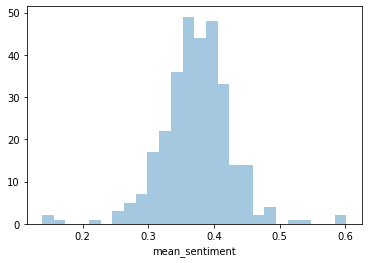

In [ ]:
sns.distplot(sofia_airbnb["mean_sentiment"], kde=False);

### Save the `mean_sentiment`s to `JSON`

In [ ]:
jsonArray = ''
for index, row in sofia_airbnb.iterrows():
    x = {
       "lat": row["lat"],
       "long": row["long"],
       "mean_sentiment": row["mean_sentiment"]
    }
    jsonArray += json.dumps(x)+','

## Topic Modelling

In [ ]:
topics = []
import nltk
nltk.download('punkt')
nltk.download('wordnet')
for index, loc in sofia_airbnb.iterrows():
    current_loc_topics = []
    for review in json.loads(loc["reviews"]):
        try:
            current_loc_topics.append(' '.join(TopicModelling(review).get_topics()[0]))
        except ValueError:
            pass
        
    topics.append(current_loc_topics)
        
sofia_airbnb["topics"] = topics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Term-Frequency x Inverse-Doc-Freq

In [ ]:
for index, loc in sofia_airbnb.iterrows():
    tf_idf = TfidfVectorizer(use_idf=True, stop_words=stop_words_en)
    X = tf_idf.fit_transform(json.loads(loc["reviews"]))
    
    tfs = np.mean(X.todense(), axis=0) * .1
    scores = np.multiply(tfs, tf_idf.idf_.reshape(tfs.shape))
    
    terms = np.array(tf_idf.get_feature_names()).reshape(tfs.shape)
    zipped = np.hstack((terms.T, scores.T)).tolist()
    print(np.array(sorted(zipped, key=lambda x: x[1], reverse=True)))
    
    print('='*100)
    print('='*100)